In [58]:
import numpy as np
from scipy.linalg import eigh, qr, null_space
import matplotlib.pyplot as plt
from scipy.sparse import kron, identity, csr_matrix, lil_matrix, dok_matrix, coo_matrix, issparse
from scipy.sparse.linalg import eigsh, eigs
from scipy.special import factorial, comb
from scipy.optimize import curve_fit
from qutip import Qobj, ptrace, entropy_vn, qeye, tensor
from tqdm import tqdm
import torch
from concurrent.futures import ThreadPoolExecutor
from joblib import Parallel, delayed
from itertools import combinations
from collections import Counter
#from quspin.basis import spin_basis_1d, spin_basis_general
#import tenpy as tp

In [67]:
# spin-1/2 basis states + spin operators

# basis states for spin-1/2 system

# |up> state
ket_p = csr_matrix([[1], [0]])

# |down> state
ket_m = csr_matrix([[0], [1]])

# Spin-1/2 operators as sparse matrices
sx = csr_matrix([[0, 1], [1, 0]], dtype=np.complex128)
sy = csr_matrix([[0, -1j], [1j, 0]], dtype=np.complex128)
sz = csr_matrix([[1, 0], [0, -1]], dtype=np.complex128)

I = identity(2, format='csr', dtype=np.complex128)

# s_+ operator
sp = (1/2) * (sx + 1j * sy)

# s_- operator
sm = (1/2) * (sx - 1j * sy)


# --- Vacuum state |omega> = |0>^{⊗L} ---
def omega(L):
    state = ket_m
    for _ in range(L-1):
        state = kron(state, ket_m, format='csr')
    return state

def omega_p(L):
    state = ket_p
    for _ in range(L-1):
        state = kron(state, ket_p, format='csr')
    return state

def hamiltonian_fredkin(L, bc):
    """
    Constructs the Fredkin Hamiltonian using sparse matrices.    
    Args:
        L: number of sites
        bc: boundary conditions ('obc' or 'pbc')
    
    Returns:
        H: sparse Hamiltonian matrix
    """
    H = csr_matrix((2**L, 2**L), dtype=np.complex128)
    
    def build_term(i, positions, operators):
        """Build a single term with specified operators at given positions"""
        term = identity(1, format='csr', dtype=np.complex128)
        for j in range(L):
            if j in positions:
                op = operators[positions.index(j)]
            else:
                op = I
            term = kron(term, op, format='csr')
        return term
    
    def add_fredkin_term(i):
        """Add all 8 terms for position i"""
        nonlocal H
        # Positions involved: i-1, i, i+1, i+2
        pos = [i-1, i, i+1, i+2]
        
        print(f"\nAdding terms for i={i} (positions: {pos})")
        
        # Define all 8 terms with descriptions
        terms = [
            ([pos[0]], [sz], f"σ^z_{{{pos[0]}}}"),                                    # term1
            ([pos[3]], [sz], f"σ^z_{{{pos[3]}}}"),                                    # term2
            (pos[:3], [sz, sx, sx], f"σ^z_{{{pos[0]}}} σ^x_{{{pos[1]}}} σ^x_{{{pos[2]}}}"),   # term3
            (pos[:3], [sz, sy, sy], f"σ^z_{{{pos[0]}}} σ^y_{{{pos[1]}}} σ^y_{{{pos[2]}}}"),   # term4
            (pos[:3], [sz, sz, sz], f"σ^z_{{{pos[0]}}} σ^z_{{{pos[1]}}} σ^z_{{{pos[2]}}}"),   # term5
            (pos[1:], [sx, sx, sz], f"σ^x_{{{pos[1]}}} σ^x_{{{pos[2]}}} σ^z_{{{pos[3]}}}"),   # term6
            (pos[1:], [sy, sy, sz], f"σ^y_{{{pos[1]}}} σ^y_{{{pos[2]}}} σ^z_{{{pos[3]}}}"),   # term7
            (pos[1:], [sz, sz, sz], f"σ^z_{{{pos[1]}}} σ^z_{{{pos[2]}}} σ^z_{{{pos[3]}}}"),   # term8
        ]
        
        # Signs: +1 for first two terms, -1 for the rest
        signs = [1, 1, -1, -1, -1, -1, -1, -1]
        
        for idx, ((positions, ops, description), sign) in enumerate(zip(terms, signs)):
            sign_str = "+" if sign > 0 else "-"
            print(f"  Term {idx+1}: {sign_str} {description}")
            H += sign * build_term(i, positions, ops)
    
    print("=== OBC TERMS ===")
    # OBC terms
    for i in range(2, L-1):
        add_fredkin_term(i)
    
    # PBC terms
    if bc == 'pbc':
        print("\n=== PBC TERMS ===")
        # Wraparound terms for i=1, i=L-1 and i=L
        for i in [1, L-1, L]:
            # Adjust positions for periodic boundary conditions
            pos = [(i-1) % L, i % L, (i+1) % L, (i+2) % L]
            
            print(f"\nAdding PBC terms for i={i} (positions: {pos})")
            
            terms = [
                ([pos[0]], [sz], f"σ^z_{{{pos[0]}}}"),
                ([pos[3]], [sz], f"σ^z_{{{pos[3]}}}"),
                (pos[:3], [sz, sx, sx], f"σ^z_{{{pos[0]}}} σ^x_{{{pos[1]}}} σ^x_{{{pos[2]}}}"),
                (pos[:3], [sz, sy, sy], f"σ^z_{{{pos[0]}}} σ^y_{{{pos[1]}}} σ^y_{{{pos[2]}}}"),
                (pos[:3], [sz, sz, sz], f"σ^z_{{{pos[0]}}} σ^z_{{{pos[1]}}} σ^z_{{{pos[2]}}}"),
                (pos[1:], [sx, sx, sz], f"σ^x_{{{pos[1]}}} σ^x_{{{pos[2]}}} σ^z_{{{pos[3]}}}"),
                (pos[1:], [sy, sy, sz], f"σ^y_{{{pos[1]}}} σ^y_{{{pos[2]}}} σ^z_{{{pos[3]}}}"),
                (pos[1:], [sz, sz, sz], f"σ^z_{{{pos[1]}}} σ^z_{{{pos[2]}}} σ^z_{{{pos[3]}}}"),
            ]
            
            signs = [1, 1, -1, -1, -1, -1, -1, -1]
            
            for idx, ((positions, ops, description), sign) in enumerate(zip(terms, signs)):
                sign_str = "+" if sign > 0 else "-"
                print(f"  Term {idx+1}: {sign_str} {description}")
                H += sign * build_term(i, positions, ops)
    
    print("\n=== HAMILTONIAN CONSTRUCTION COMPLETE ===")
    return H

'''def hamiltonian_fredkin(L, bc):
    """
    Constructs the Fredkin Hamiltonian using sparse matrices.    
    Args:
        L: number of sites
        bc: boundary conditions ('obc' or 'pbc')
    
    Returns:
        H: sparse Hamiltonian matrix
    """
    H = csr_matrix((2**L, 2**L), dtype=np.complex128)
    
    # OBC terms
    for i in range(2, L-1):  # i goes from 2 to L-2 (inclusive)
        # Initialize all terms as identity for the first site
        term1 = identity(1, format='csr', dtype=np.complex128)
        term2 = identity(1, format='csr', dtype=np.complex128)
        term3 = identity(1, format='csr', dtype=np.complex128)
        term4 = identity(1, format='csr', dtype=np.complex128)
        term5 = identity(1, format='csr', dtype=np.complex128)
        term6 = identity(1, format='csr', dtype=np.complex128)
        term7 = identity(1, format='csr', dtype=np.complex128)
        term8 = identity(1, format='csr', dtype=np.complex128)
        
        for j in range(L):  # j goes from 0 to L-1 (0-indexed)
            if j == i-1:  # i-1 position
                term1 = kron(term1, sz, format='csr')
                term2 = kron(term2, I, format='csr')
                term3 = kron(term3, sz, format='csr')
                term4 = kron(term4, sz, format='csr')
                term5 = kron(term5, sz, format='csr')
                term6 = kron(term6, I, format='csr')
                term7 = kron(term7, I, format='csr')
                term8 = kron(term8, I, format='csr')
            elif j == i:  # i position
                term1 = kron(term1, I, format='csr')
                term2 = kron(term2, I, format='csr')
                term3 = kron(term3, sx, format='csr')
                term4 = kron(term4, sy, format='csr')
                term5 = kron(term5, sz, format='csr')
                term6 = kron(term6, sx, format='csr')
                term7 = kron(term7, sy, format='csr')
                term8 = kron(term8, sz, format='csr')
            elif j == i+1:  # i+1 position
                term1 = kron(term1, I, format='csr')
                term2 = kron(term2, I, format='csr')
                term3 = kron(term3, sx, format='csr')
                term4 = kron(term4, sy, format='csr')
                term5 = kron(term5, sz, format='csr')
                term6 = kron(term6, sx, format='csr')
                term7 = kron(term7, sy, format='csr')
                term8 = kron(term8, sz, format='csr')
            elif j == i+2:  # i+2 position
                term1 = kron(term1, I, format='csr')
                term2 = kron(term2, sz, format='csr')
                term3 = kron(term3, I, format='csr')
                term4 = kron(term4, I, format='csr')
                term5 = kron(term5, I, format='csr')
                term6 = kron(term6, sz, format='csr')
                term7 = kron(term7, sz, format='csr')
                term8 = kron(term8, sz, format='csr')
            else:  # all other positions
                term1 = kron(term1, I, format='csr')
                term2 = kron(term2, I, format='csr')
                term3 = kron(term3, I, format='csr')
                term4 = kron(term4, I, format='csr')
                term5 = kron(term5, I, format='csr')
                term6 = kron(term6, I, format='csr')
                term7 = kron(term7, I, format='csr')
                term8 = kron(term8, I, format='csr')
        
        H += (term1 + term2 - term3 - term4 - term5 - term6 - term7 - term8)

    if bc == 'pbc':
        # Add the wraparound terms for PBC
        # For i=1 (wrapping around)
        a1 = identity(1, format='csr', dtype=np.complex128)
        a2 = identity(1, format='csr', dtype=np.complex128)
        a3 = identity(1, format='csr', dtype=np.complex128)
        a4 = identity(1, format='csr', dtype=np.complex128)
        a5 = identity(1, format='csr', dtype=np.complex128)
        a6 = identity(1, format='csr', dtype=np.complex128)
        a7 = identity(1, format='csr', dtype=np.complex128)
        a8 = identity(1, format='csr', dtype=np.complex128)
        
        for j in range(L):
            if j == 0:  # i-1 position (wrapping)
                a1 = kron(a1, sz, format='csr')
                a2 = kron(a2, I, format='csr')
                a3 = kron(a3, sz, format='csr')
                a4 = kron(a4, sz, format='csr')
                a5 = kron(a5, sz, format='csr')
                a6 = kron(a6, I, format='csr')
                a7 = kron(a7, I, format='csr')
                a8 = kron(a8, I, format='csr')
            elif j == 1:  # i position
                a1 = kron(a1, I, format='csr')
                a2 = kron(a2, I, format='csr')
                a3 = kron(a3, sx, format='csr')
                a4 = kron(a4, sy, format='csr')
                a5 = kron(a5, sz, format='csr')
                a6 = kron(a6, sx, format='csr')
                a7 = kron(a7, sy, format='csr')
                a8 = kron(a8, sz, format='csr')
            elif j == 2:  # i+1 position
                a1 = kron(a1, I, format='csr')
                a2 = kron(a2, I, format='csr')
                a3 = kron(a3, sx, format='csr')
                a4 = kron(a4, sy, format='csr')
                a5 = kron(a5, sz, format='csr')
                a6 = kron(a6, sx, format='csr')
                a7 = kron(a7, sy, format='csr')
                a8 = kron(a8, sz, format='csr')
            elif j == 3:  # i+2 position
                a1 = kron(a1, I, format='csr')
                a2 = kron(a2, sz, format='csr')
                a3 = kron(a3, I, format='csr')
                a4 = kron(a4, I, format='csr')
                a5 = kron(a5, I, format='csr')
                a6 = kron(a6, sz, format='csr')
                a7 = kron(a7, sz, format='csr')
                a8 = kron(a8, sz, format='csr')
            else:
                a1 = kron(a1, I, format='csr')
                a2 = kron(a2, I, format='csr')
                a3 = kron(a3, I, format='csr')
                a4 = kron(a4, I, format='csr')
                a5 = kron(a5, I, format='csr')
                a6 = kron(a6, I, format='csr')
                a7 = kron(a7, I, format='csr')
                a8 = kron(a8, I, format='csr')
        
        H += (a1 + a2 - a3 - a4 - a5 - a6 - a7 - a8)
        
        # For i=L-1 (wrapping around)
        b1 = identity(1, format='csr', dtype=np.complex128)
        b2 = identity(1, format='csr', dtype=np.complex128)
        b3 = identity(1, format='csr', dtype=np.complex128)
        b4 = identity(1, format='csr', dtype=np.complex128)
        b5 = identity(1, format='csr', dtype=np.complex128)
        b6 = identity(1, format='csr', dtype=np.complex128)
        b7 = identity(1, format='csr', dtype=np.complex128)
        b8 = identity(1, format='csr', dtype=np.complex128)
        
        for j in range(L):
            if j == L-2:  # i-1 position
                b1 = kron(b1, sz, format='csr')
                b2 = kron(b2, I, format='csr')
                b3 = kron(b3, sz, format='csr')
                b4 = kron(b4, sz, format='csr')
                b5 = kron(b5, sz, format='csr')
                b6 = kron(b6, I, format='csr')
                b7 = kron(b7, I, format='csr')
                b8 = kron(b8, I, format='csr')
            elif j == L-1:  # i position
                b1 = kron(b1, I, format='csr')
                b2 = kron(b2, I, format='csr')
                b3 = kron(b3, sx, format='csr')
                b4 = kron(b4, sy, format='csr')
                b5 = kron(b5, sz, format='csr')
                b6 = kron(b6, sx, format='csr')
                b7 = kron(b7, sy, format='csr')
                b8 = kron(b8, sz, format='csr')
            elif j == 0:  # i+1 position (wrapping)
                b1 = kron(b1, I, format='csr')
                b2 = kron(b2, I, format='csr')
                b3 = kron(b3, sx, format='csr')
                b4 = kron(b4, sy, format='csr')
                b5 = kron(b5, sz, format='csr')
                b6 = kron(b6, sx, format='csr')
                b7 = kron(b7, sy, format='csr')
                b8 = kron(b8, sz, format='csr')
            elif j == 1:  # i+2 position (wrapping)
                b1 = kron(b1, I, format='csr')
                b2 = kron(b2, sz, format='csr')
                b3 = kron(b3, I, format='csr')
                b4 = kron(b4, I, format='csr')
                b5 = kron(b5, I, format='csr')
                b6 = kron(b6, sz, format='csr')
                b7 = kron(b7, sz, format='csr')
                b8 = kron(b8, sz, format='csr')
            else:
                b1 = kron(b1, I, format='csr')
                b2 = kron(b2, I, format='csr')
                b3 = kron(b3, I, format='csr')
                b4 = kron(b4, I, format='csr')
                b5 = kron(b5, I, format='csr')
                b6 = kron(b6, I, format='csr')
                b7 = kron(b7, I, format='csr')
                b8 = kron(b8, I, format='csr')
        
        H += (b1 + b2 - b3 - b4 - b5 - b6 - b7 - b8)
    
    return H'''

'def hamiltonian_fredkin(L, bc):\n    """\n    Constructs the Fredkin Hamiltonian using sparse matrices.    \n    Args:\n        L: number of sites\n        bc: boundary conditions (\'obc\' or \'pbc\')\n    \n    Returns:\n        H: sparse Hamiltonian matrix\n    """\n    H = csr_matrix((2**L, 2**L), dtype=np.complex128)\n    \n    # OBC terms\n    for i in range(2, L-1):  # i goes from 2 to L-2 (inclusive)\n        # Initialize all terms as identity for the first site\n        term1 = identity(1, format=\'csr\', dtype=np.complex128)\n        term2 = identity(1, format=\'csr\', dtype=np.complex128)\n        term3 = identity(1, format=\'csr\', dtype=np.complex128)\n        term4 = identity(1, format=\'csr\', dtype=np.complex128)\n        term5 = identity(1, format=\'csr\', dtype=np.complex128)\n        term6 = identity(1, format=\'csr\', dtype=np.complex128)\n        term7 = identity(1, format=\'csr\', dtype=np.complex128)\n        term8 = identity(1, format=\'csr\', dtype=np.complex12

In [60]:
'''
def partial_trace_qubit(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits."""
    keep_dims = np.prod([dims[i] for i in keep])
    trace_dims = np.prod([dims[i] for i in range(len(dims)) if i not in keep])
    rho = rho.reshape([keep_dims, trace_dims, keep_dims, trace_dims])
    return np.trace(rho, axis1=1, axis2=3).reshape([keep_dims, keep_dims])

def partial_trace_qubit_torch(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits using PyTorch."""
    keep_dims = torch.prod(torch.tensor([dims[i] for i in keep]))
    trace_dims = torch.prod(torch.tensor([dims[i] for i in range(len(dims)) if i not in keep]))
    rho = rho.view(keep_dims, trace_dims, keep_dims, trace_dims)
    # Compute the partial trace
    traced_rho = torch.zeros((keep_dims, keep_dims), dtype=rho.dtype)
    for i in range(trace_dims):
        traced_rho += rho[:, i, :, i]
    #return traced_rho.view(keep_dims, keep_dims)
    return traced_rho'''

def isket_numpy(arr):
    """
    Check if a NumPy array is a ket (column vector).

    Parameters:
    - arr: np.ndarray, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input must be a NumPy array")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_numpy(Q, sel, dims): # numpy function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using NumPy.

    Parameters:
    - Q: numpy object, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - numpy object, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = np.asarray(dims[0], dtype=np.int32).ravel()
    nd = len(rd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = np.array([sel])
    else:
        sel = np.asarray(sel)
    sel = list(np.sort(sel))
    
    # Dimensions of the subsystems to keep
    dkeep = (rd[sel]).tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(np.arange(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = (rd[qtrace]).tolist()
    
    # Reshape the density matrix or state vector
    rd = list(rd)
    if isket_numpy(Q):
        # Reshape and transpose for state vector
        vmat = (Q
                .reshape(rd)
                .transpose(sel + qtrace)
                .reshape([np.prod(dkeep), np.prod(dtrace)]))
        # Compute the reduced density matrix
        rhomat = vmat.dot(vmat.conj().T)
    else:
        # Reshape and transpose for density matrix
        rhomat = np.trace(Q
                          .reshape(rd + rd)
                          .transpose(qtrace + [nd + q for q in qtrace] +
                                     sel + [nd + q for q in sel])
                          .reshape([np.prod(dtrace),
                                    np.prod(dtrace),
                                    np.prod(dkeep),
                                    np.prod(dkeep)]))
    return rhomat


def ptrace_sparse(psi_sparse, keep, dims):
    """
    Compute the partial trace over arbitrary subsystems using sparse matrix operations.

    Args:
        psi_sparse (scipy.sparse matrix): Full density matrix of shape (D, D), where D = product(dims)
        keep (list of int): Subsystems to keep (indices, 0-indexed)
        dims (list of int): List of subsystem dimensions, e.g., [2]*n for n qubits

    Returns:
        scipy.sparse.csr_matrix: Reduced density matrix over kept subsystems
    """
    if not issparse(psi_sparse):
        raise ValueError("psi_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if psi_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])
    # Prepare output
    data = []
    row_idx = []
    col_idx = []

    # Precompute bit masks
    def idx_to_bits(idx):
        return np.array(list(np.binary_repr(idx, width=n))).astype(int)
    

    psi_sparse = psi_sparse.tocoo()
    for i, j, val in zip(psi_sparse.row, psi_sparse.col, psi_sparse.data):
        bi = idx_to_bits(i)
        bj = idx_to_bits(j)


        # Only sum terms where traced-out subsystems agree
        if np.all(bi[trace] == bj[trace]):
            # Extract kept bits and convert to reduced indices
            #print('condition met for i, j:', i, j)
            i_red_bits = bi[keep]
            j_red_bits = bj[keep]
            i_red = int("".join(i_red_bits.astype(str)), 2)
            j_red = int("".join(j_red_bits.astype(str)), 2)


            data.append(val)
            row_idx.append(i_red)
            col_idx.append(j_red)
    
    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()


def isket_torch(arr):
    """
    Check if a PyTorch tensor is a ket (column vector).

    Parameters:
    - arr: torch.Tensor, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, torch.Tensor):
        raise ValueError("Input must be a PyTorch tensor")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_torch(Q, sel, dims): # torch function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using PyTorch.

    Parameters:
    - Q: torch.Tensor, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - torch.Tensor, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = torch.tensor(dims[0], dtype=torch.int32).flatten()
    nd = len(rd)
    #print("rd", rd)
    #print("nd", nd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = torch.tensor([sel])
    else:
        sel = torch.tensor(sel)
    sel = torch.sort(sel).values.tolist()
    
    # Dimensions of the subsystems to keep
    dkeep = rd[sel].tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(range(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = rd[qtrace].tolist()
    
    # Reshape the density matrix or state vector
    rd = rd.tolist()
    if isket_torch(Q):
        # Reshape and transpose for state vector
        reshaped_Q = Q.reshape(rd)
        #print(reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(sel + qtrace)
        #print(transposed_Q.shape)
        vmat = transposed_Q.reshape([torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dtrace))])
        #print(vmat.shape)
        # Compute the reduced density matrix
        rhomat = vmat @ vmat.conj().T
        #print(rhomat.shape)
    else:
        # Reshape and transpose for density matrix
        reshaped_Q = Q.reshape(rd + rd)
        #print("reshaped_Q", reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(qtrace + [nd + q for q in qtrace] + sel + [nd + q for q in sel])
        #print("transposed_Q", transposed_Q.shape)
        reshaped_transposed_Q = transposed_Q.reshape([torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))])
        #print("reshaped_transposed_Q", reshaped_transposed_Q.shape)
        #rhomat = torch.trace(reshaped_transposed_Q)
        rhomat = torch.einsum('iikl->kl', reshaped_transposed_Q)
        # Trace out the first two dimensions
        #rhomat = torch.zeros((torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))), dtype=Q.dtype)
        #for i in range(reshaped_transposed_Q.shape[0]):
        #    for j in range(reshaped_transposed_Q.shape[1]):
        #        rhomat += reshaped_transposed_Q[i, j, :, :]
        #print("rhomat", rhomat.shape)
    return rhomat

def entanglement_entropy(psi, subsystem, total_size):

    '''Computes the bipartite entanglement entropy of a pure state.
    
    Parameters:
    psi : np.array
        The wavefunction (state vector) of the full system.
    subsystem_size : int
        The number of qubits in subsystem A.
    total_size : int
        The total number of qubits in the system.
    
    Returns:
    float
        The von Neumann entanglement entropy S_A.'''
    
    psi_matrix =  np.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_numpy(psi_matrix, subsystem, [[2]*total_size, [2]*total_size])  # Partial trace over B
    
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rho_A)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch(psi, subsystem, total_size):
    """
    Computes the bipartite entanglement entropy of a pure state using PyTorch.

    Parameters:
    - psi: torch.Tensor (complex), the wavefunction (state vector) of the full system.
    - subsystem_size: int, the number of qubits in subsystem A.
    - total_size: int, the total number of qubits in the system.

    Returns:
    - torch.Tensor (scalar), the von Neumann entanglement entropy S_A.
    """

    if not isinstance(psi, torch.Tensor):
        psi = torch.tensor(psi, dtype=torch.complex64)
    
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Compute the density matrix |psi><psi|
    psi_matrix = torch.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_torch(psi_matrix, subsystem, [[2] * total_size, [2] * total_size])  # Partial trace over B

    #rho_A = rho_A.to(dtype=torch.float64)
    
    # Compute eigenvalues of rho_A
    eigvals = torch.linalg.eigvalsh(rho_A)

    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigvals = eigvals[eigvals > 0]

    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -torch.sum(eigvals * torch.log2(eigvals))

    return entropy

def entanglement_entropy_qutip(psi, subsystem, total_size):
    
    # Convert the wavefunction to a QuTiP Qobj
    density_matrix = np.outer(psi, psi.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*total_size, [2]*total_size])

    rho_A = ptrace(density_matrix_qobj, subsystem)
    # Compute the von Neumann entropy S_A
    entropy = entropy_vn(rho_A, base=2)
    
    return entropy

def entanglement_entropy_np_ptrace(rdm):
    # rdm already computed and converted to numpy
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rdm)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch_ptrace(rdm):

    eigvals = torch.linalg.eigvalsh(rdm)
    eigvals = eigvals[eigvals > 0]
    entropy = -torch.sum(eigvals * torch.log2(eigvals))
    return entropy


def entanglement_entropy_qutip_torch(psi, N):
    """
    Compute the von Neumann entanglement entropy using qutip.

    Parameters:
    - psi: torch.Tensor (complex), state vector of a quantum system.
    - N: int, total number of qubits.

    Returns:
    - torch.Tensor (scalar), von Neumann entropy.
    """
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Convert PyTorch tensor to NumPy for QuTiP
    psi_np = psi.detach().numpy()

    rho_np = np.outer(psi_np, psi_np.conj())
    rho_qobj = Qobj(rho_np, dims=[[2] * N, [2] * N])

    rho_A = ptrace(rho_qobj, list(range(N // 2)))

    # Compute von Neumann entropy
    entropy = entropy_vn(rho_A, base=2)  # Compute in log base 2

    # Convert back to PyTorch tensor to allow gradient flow
    return torch.tensor(entropy, dtype=torch.float32, requires_grad=True)

#######################################################################################################################

# Define the linear combination function - numpy
def linear_combination_np(coeffs, psis):
    # Ensure psis are numpy tensors
    psi_np = [np.array(psi) for psi in psis]
    # Compute the linear combination in PyTorch
    psi = sum(c * psi for c, psi in zip(coeffs, psis))
    
    return psi

# Define the linear combination function - torch
def linear_combination(coeffs, psis):
    # Ensure psis are PyTorch tensors
    psis_torch = [torch.tensor(psi, dtype=torch.complex64) if not isinstance(psi, torch.Tensor) else psi for psi in psis]
    
    # Compute the linear combination in PyTorch
    psi_torch = sum(c * psi for c, psi in zip(coeffs, psis_torch))
    
    return psi_torch

# Define the linear combination function - torch but after computing the ptrace of outer products of scars
def linear_combination_outer(coeffs, outs):
    # Ensure outs are PyTorch tensors
    outs_torch = [torch.tensor(out, dtype=torch.complex64) if not isinstance(out, torch.Tensor) else out for out in outs]
    torch_coeffs = torch.tensor(coeffs, dtype=torch.complex64)

    # Compute the PyTorch tensor of out_coeffs which is the product of all possible combinations of c_i^* times c_j
    out_coeffs = torch.zeros((len(torch_coeffs), len(torch_coeffs)), dtype=torch.complex64)
    for i in range(len(torch_coeffs)):
        for j in range(len(torch_coeffs)):
            out_coeffs[i, j] = torch.conj(torch_coeffs[i]) * torch_coeffs[j]
    
    # Compute the linear combination in PyTorch
    lin_torch = sum(out_coeffs[i, j] * outs_torch[i] for i in range(len(coeffs)) for j in range(len(coeffs)))
    
    return lin_torch

######################################################

# Function to apply permutation to a given spin configuration
def apply_permutation(state_bits, N, perm):
    new_bits = [0] * N
    for i in range(N):
        new_bits[perm[i]] = state_bits[i]  # Map value at index i to perm[i]
    return new_bits

# Function to convert an index to its binary representation
def index_to_binary(index, num_qubits):
    return format(index, f'0{num_qubits}b')

In [61]:
# more functions

def innermost_adjacent_indices(L, block_size):
    """
    Returns the indices of the innermost adjacent block of given size.
    For even L, the block is centered in the middle.
    """
    start = (L - block_size) // 2
    return list(range(start, start + block_size))

def all_adjacent_indices(L, block_size):
    """
    Returns a list of all possible adjacent blocks of given size.
    Each block is represented as a list of indices.
    """
    return [list(range(start, start + block_size)) for start in range(L - block_size + 1)]

def ptrace_sparse(dm_sparse, keep, dims):
    """
    Compute the partial trace over arbitrary subsystems using sparse matrix operations.

    Args:
        dm_sparse (scipy.sparse matrix): Full density matrix of shape (D, D), where D = product(dims)
        keep (list of int): Subsystems to keep (indices, 0-indexed)
        dims (list of int): List of subsystem dimensions, e.g., [2]*n for n qubits

    Returns:
        scipy.sparse.csr_matrix: Reduced density matrix over kept subsystems
    """
    if not issparse(dm_sparse):
        raise ValueError("dm_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if dm_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])
    # Prepare output
    data = []
    row_idx = []
    col_idx = []

    # Precompute bit masks
    #def idx_to_bits(idx):
    #    return np.array(list(np.binary_repr(idx, width=n))).astype(int)

    def idx_to_subsys(idx, dims):
    #Convert flat index to tuple of subsystem indices for arbitrary dims.
        subsys = []
        for d in reversed(dims):
            subsys.append(idx % d)
            idx //= d
        return np.array(subsys[::-1])

    

    dm_sparse = dm_sparse.tocoo()

    for i, j, val in tqdm(zip(dm_sparse.row, dm_sparse.col, dm_sparse.data)):
        bi = idx_to_subsys(i, dims)
        bj = idx_to_subsys(j, dims)

        if np.all(bi[trace] == bj[trace]):
            i_red = 0
            j_red = 0
            for k, pos in enumerate(keep):
                i_red = i_red * dims[pos] + bi[pos]
                j_red = j_red * dims[pos] + bj[pos]

            data.append(val)
            row_idx.append(i_red)
            col_idx.append(j_red)

    
    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()

def ptrace_sparse_parallel(dm_sparse, keep, dims, n_jobs=-1): # njobs to be removed if not using joblib
    """
    Compute the partial trace over arbitrary subsystems using sparse matrix operations.
    Parallelized over nonzero elements.
    """
    if not issparse(dm_sparse):
        raise ValueError("dm_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if dm_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])


    def idx_to_subsys(idx, dims):
    #Convert flat index to tuple of subsystem indices for arbitrary dims.
        subsys = []
        for d in reversed(dims):
            subsys.append(idx % d)
            idx //= d
        return np.array(subsys[::-1])

    
    dm_sparse = dm_sparse.tocoo()

    def process_entry(i,j,val):
        bi = idx_to_subsys(i, dims)
        bj = idx_to_subsys(j, dims)

        if np.all(bi[trace] == bj[trace]):
            i_red = 0
            j_red = 0
            for k, pos in enumerate(keep):
                i_red = i_red * dims[pos] + bi[pos]
                j_red = j_red * dims[pos] + bj[pos]
            return (val, i_red, j_red)
        else:
            return None
        
    results = Parallel(n_jobs=n_jobs, prefer="processes")(
        delayed(process_entry)(i, j, val)
        for i, j, val in tqdm(zip(dm_sparse.row, dm_sparse.col, dm_sparse.data))
    )
    results = [r for r in results if r is not None]

    '''entries = zip(psi_sparse.row, psi_sparse.col, psi_sparse.data)
    results = []
    with ThreadPoolExecutor() as executor:
        for res in executor.map(process_entry, entries):
            if res is not None:
                results.append(res)'''
    
    if results:
        data, row_idx, col_idx = zip(*results)
    else:
        data, row_idx, col_idx = [], [], []

    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()

def ee_sparse(dm_sparse, L):
    """
    Computes the entanglement entropy of a state using sparse matrices in parallel.
    The state is assumed to be a vector in the Hilbert space of L qubits.
    """
    rhoA = ptrace_sparse(dm_sparse, list(range(L // 2)), [2] * L)
    eigvals = np.linalg.eigvalsh(rhoA.toarray())
    return -np.sum(eigvals * np.log(eigvals + 1e-12)).real  # Add small value to avoid log(0)

def ee_sparse_parallel(dm_sparse, L, n_jobs=-1):
    """
    Computes the entanglement entropy of a state using sparse matrices in parallel.
    The state is assumed to be a vector in the Hilbert space of L qubits.
    """
    rhoA = ptrace_sparse_parallel(dm_sparse, list(range(L // 2)), [2] * L, n_jobs=n_jobs)
    eigvals = np.linalg.eigvalsh(rhoA.toarray())
    return -np.sum(eigvals * np.log(eigvals + 1e-12)).real  # Add small value to avoid log(0)

def rdm_qutip(state, L, keep_qubits):
    rho = np.outer(state, state.conj())
    rho_qobj = Qobj(rho, dims=[[2] * L, [2] * L])
    rdm = ptrace(rho_qobj, keep_qubits)
    rdm_mat = rdm.full()
    eigvals = np.linalg.eigvalsh(rdm_mat)
    min_eigval = np.min(eigvals)
    # Rank: count nonzero eigenvalues (with tolerance)
    rank = np.sum(eigvals > 1e-12)
    return rdm, min_eigval, rank

def ee_qutip(state, L):
    rho = np.outer(state, state.conj())
    rho_qobj = Qobj(rho, dims=[[2] * L, [2] * L])
    rhoA = ptrace(rho_qobj, list(range(L//2)))
    return entropy_vn(rhoA)

In [68]:
L = 4  # Number of spins
bc = 'pbc'  # Boundary condition


# Assuming transverse_field_ising is defined and returns a sparse Hermitian matrix
H = hamiltonian_fredkin(L, bc)

#print(f"Hamiltonian shape: {H.shape}")
#print(f"Non-zero elements in H: {H.nnz}")

innermost_2 = innermost_adjacent_indices(L, 2)
innermost_3 = innermost_adjacent_indices(L, 3)
innermost_4 = innermost_adjacent_indices(L, 4)

adjacent_2 = all_adjacent_indices(L, 2)
adjacent_3 = all_adjacent_indices(L, 3)
adjacent_4 = all_adjacent_indices(L, 4)

print("All adjacent 2-site blocks:", adjacent_2)
print("All adjacent 3-site blocks:", adjacent_3)
print("All adjacent 4-site blocks:", adjacent_4)

=== OBC TERMS ===

Adding terms for i=2 (positions: [1, 2, 3, 4])
  Term 1: + σ^z_{1}
  Term 2: + σ^z_{4}
  Term 3: - σ^z_{1} σ^x_{2} σ^x_{3}
  Term 4: - σ^z_{1} σ^y_{2} σ^y_{3}
  Term 5: - σ^z_{1} σ^z_{2} σ^z_{3}
  Term 6: - σ^x_{2} σ^x_{3} σ^z_{4}
  Term 7: - σ^y_{2} σ^y_{3} σ^z_{4}
  Term 8: - σ^z_{2} σ^z_{3} σ^z_{4}

=== PBC TERMS ===

Adding PBC terms for i=1 (positions: [0, 1, 2, 3])
  Term 1: + σ^z_{0}
  Term 2: + σ^z_{3}
  Term 3: - σ^z_{0} σ^x_{1} σ^x_{2}
  Term 4: - σ^z_{0} σ^y_{1} σ^y_{2}
  Term 5: - σ^z_{0} σ^z_{1} σ^z_{2}
  Term 6: - σ^x_{1} σ^x_{2} σ^z_{3}
  Term 7: - σ^y_{1} σ^y_{2} σ^z_{3}
  Term 8: - σ^z_{1} σ^z_{2} σ^z_{3}

Adding PBC terms for i=3 (positions: [2, 3, 0, 1])
  Term 1: + σ^z_{2}
  Term 2: + σ^z_{1}
  Term 3: - σ^z_{2} σ^x_{3} σ^x_{0}
  Term 4: - σ^z_{2} σ^y_{3} σ^y_{0}
  Term 5: - σ^z_{2} σ^z_{3} σ^z_{0}
  Term 6: - σ^x_{3} σ^x_{0} σ^z_{1}
  Term 7: - σ^y_{3} σ^y_{0} σ^z_{1}
  Term 8: - σ^z_{3} σ^z_{0} σ^z_{1}

Adding PBC terms for i=4 (positions: [3, 0

In [53]:
# All eigenvalues of H
# Compute all eigenvalues and corresponding eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H.toarray())

print(f"Eigenvalues of H: {np.sort(eigenvalues)}")

# Count the number of (near-)zero components in each eigenvector
zero_threshold = 1e-16
nzero_counts = []
for i in range(eigenvectors.shape[1]):
    num_nzeros = np.sum(np.abs(eigenvectors[:, i]) > zero_threshold)
    nzero_counts.append(num_nzeros)
    print(f"Eigenvalue {eigenvalues[i]}, Eigenvector {i}: {num_nzeros} components > {zero_threshold}")

'''# Optionally, print a summary
print("Zero count distribution:", Counter(zero_counts))

# Check if each eigenvector is complex or real
for i in range(eigenvectors.shape[1]):
    vec = eigenvectors[:, i]
    if np.any(np.abs(vec.imag) > 1e-16):
        print(f"Eigenvector {i} is complex.")
    #else:
    #    print(f"Eigenvector {i} is real.")'''

Eigenvalues of H: [-40.5036902  -37.8579239  -37.55683514 ...  40.66445152  41.33908372
  43.95023404]
Eigenvalue -40.50369019686895, Eigenvector 0: 102 components > 1e-16
Eigenvalue -37.857923902103074, Eigenvector 1: 117 components > 1e-16
Eigenvalue -37.55683513504868, Eigenvector 2: 109 components > 1e-16
Eigenvalue -36.11311225423044, Eigenvector 3: 114 components > 1e-16
Eigenvalue -34.6899174454932, Eigenvector 4: 64 components > 1e-16
Eigenvalue -34.02983255502251, Eigenvector 5: 88 components > 1e-16
Eigenvalue -33.09956035779375, Eigenvector 6: 153 components > 1e-16
Eigenvalue -32.8137071199548, Eigenvector 7: 191 components > 1e-16
Eigenvalue -31.90241015639758, Eigenvector 8: 134 components > 1e-16
Eigenvalue -31.51087165975422, Eigenvector 9: 137 components > 1e-16
Eigenvalue -30.865034850175245, Eigenvector 10: 232 components > 1e-16
Eigenvalue -30.69180873206616, Eigenvector 11: 143 components > 1e-16
Eigenvalue -30.45406081417474, Eigenvector 12: 69 components > 1e-16


'# Optionally, print a summary\nprint("Zero count distribution:", Counter(zero_counts))\n\n# Check if each eigenvector is complex or real\nfor i in range(eigenvectors.shape[1]):\n    vec = eigenvectors[:, i]\n    if np.any(np.abs(vec.imag) > 1e-16):\n        print(f"Eigenvector {i} is complex.")\n    #else:\n    #    print(f"Eigenvector {i} is real.")'

In [54]:
scar_indices = []
for i in range(len(eigenvalues)):
    if eigenvalues[i] == 0:
        scar_indices.append(i)
print(f"Indices of scars: {scar_indices}")

Indices of scars: [1895, 1896]


In [55]:
# Compute bipartite entanglement entropy for all eigenstates in the full Hilbert space
half = [0,1,2,3,4,5]  # Indices of the first half of the system (for L=12)
numpy_entropies = [entanglement_entropy(eigenvectors[:, i], half, L) for i in tqdm(range(eigenvectors.shape[1]))]

100%|██████████| 4096/4096 [08:15<00:00,  8.27it/s]


Entropies of red points:
Index: 1895, Entropy: -0.0
Index: 1896, Entropy: -0.0


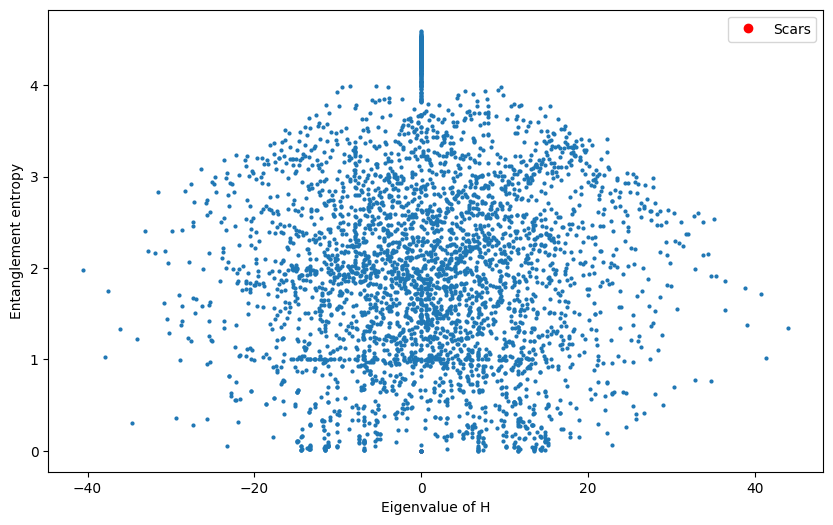

In [56]:
# Print entropies of red points only
print("Entropies of red points:")
for i in scar_indices:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y == 0 else 'C0' for y in eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)


# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

#plt.xlim(-1, 1)
#plt.ylim(0, 1e-30)
plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
plt.legend()
plt.show()

In [57]:
for i in range(len(eigenvalues)):
    scar_state = eigenvectors[:, i]

    scar_sparse = csr_matrix(scar_state.reshape(-1, 1))  # Convert to sparse column vector
    density_matrix_sparse = scar_sparse @ scar_sparse.getH()  # Outer product to form density matrix
    density_matrix_qobj = Qobj(density_matrix_sparse, dims=[[2]*L, [2]*L])  # Convert to Qobj for qutip

    # Calculate RDMs for all possible adjacent 2, 3, 4 site blocks
    for block_size, all_blocks in zip([2, 3, 4], [adjacent_2, adjacent_3, adjacent_4]):
        print(f"\nAll possible RDMs for block size {block_size}:")
        for block_indices in tqdm(all_blocks):
            rdm = ptrace(density_matrix_qobj, block_indices)
            # Find the minimum eigenvalue of the traced-out density matrix
            eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.full())
            rank = np.linalg.matrix_rank(rdm.full())
            min_eigenvalue = np.min(eigenvalues_traced)
            print(f"Index i={i}, Block {block_indices}: min eigenvalue = {min_eigenvalue}, rank = {rank}")

    '''rdm = ptrace(density_matrix_qobj, adjacent_4[0])
    # Find the minimum eigenvalue of the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.full())
    rank = np.linalg.matrix_rank(rdm.full())
    min_eigenvalue = np.min(eigenvalues_traced)
    print(f"min eigenvalue = {min_eigenvalue}, rank = {rank}")'''


All possible RDMs for block size 2:


  9%|▉         | 1/11 [00:00<00:05,  1.72it/s]

Index i=0, Block [0, 1]: min eigenvalue = 0.0, rank = 3


 27%|██▋       | 3/11 [00:01<00:05,  1.58it/s]

Index i=0, Block [1, 2]: min eigenvalue = 0.0, rank = 3
Index i=0, Block [2, 3]: min eigenvalue = 0.0, rank = 3


 45%|████▌     | 5/11 [00:02<00:03,  1.66it/s]

Index i=0, Block [3, 4]: min eigenvalue = 0.0, rank = 3
Index i=0, Block [4, 5]: min eigenvalue = 0.0, rank = 3


 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

Index i=0, Block [5, 6]: min eigenvalue = 1.7609454088920866e-10, rank = 4
Index i=0, Block [6, 7]: min eigenvalue = 0.0, rank = 3


 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

Index i=0, Block [7, 8]: min eigenvalue = 5.89278569635432e-06, rank = 4


 91%|█████████ | 10/11 [00:06<00:00,  1.61it/s]

Index i=0, Block [8, 9]: min eigenvalue = 0.0, rank = 3
Index i=0, Block [9, 10]: min eigenvalue = 0.006590631945608555, rank = 4


100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


Index i=0, Block [10, 11]: min eigenvalue = 0.0, rank = 3

All possible RDMs for block size 3:


 10%|█         | 1/10 [00:00<00:06,  1.47it/s]

Index i=0, Block [0, 1, 2]: min eigenvalue = 0.0, rank = 5


 20%|██        | 2/10 [00:01<00:05,  1.36it/s]

Index i=0, Block [1, 2, 3]: min eigenvalue = -5.551115123125784e-17, rank = 5
Index i=0, Block [2, 3, 4]: min eigenvalue = 0.0, rank = 5


 40%|████      | 4/10 [00:02<00:03,  1.52it/s]

Index i=0, Block [3, 4, 5]: min eigenvalue = -9.543147151740348e-31, rank = 5


 50%|█████     | 5/10 [00:03<00:03,  1.43it/s]

Index i=0, Block [4, 5, 6]: min eigenvalue = 0.0, rank = 6


 60%|██████    | 6/10 [00:04<00:02,  1.47it/s]

Index i=0, Block [5, 6, 7]: min eigenvalue = -3.4694469519536635e-17, rank = 6


 70%|███████   | 7/10 [00:04<00:01,  1.53it/s]

Index i=0, Block [6, 7, 8]: min eigenvalue = 0.0, rank = 6


 80%|████████  | 8/10 [00:05<00:01,  1.51it/s]

Index i=0, Block [7, 8, 9]: min eigenvalue = -1.3877787807814947e-17, rank = 6


 90%|█████████ | 9/10 [00:06<00:00,  1.49it/s]

Index i=0, Block [8, 9, 10]: min eigenvalue = 0.0, rank = 6


100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


Index i=0, Block [9, 10, 11]: min eigenvalue = 0.0, rank = 6

All possible RDMs for block size 4:


 11%|█         | 1/9 [00:00<00:05,  1.53it/s]

Index i=0, Block [0, 1, 2, 3]: min eigenvalue = 0.0, rank = 8


 22%|██▏       | 2/9 [00:01<00:04,  1.51it/s]

Index i=0, Block [1, 2, 3, 4]: min eigenvalue = 0.0, rank = 8


 33%|███▎      | 3/9 [00:01<00:03,  1.51it/s]

Index i=0, Block [2, 3, 4, 5]: min eigenvalue = -1.4111766194464308e-17, rank = 8


 44%|████▍     | 4/9 [00:02<00:03,  1.57it/s]

Index i=0, Block [3, 4, 5, 6]: min eigenvalue = 0.0, rank = 9


 56%|█████▌    | 5/9 [00:03<00:02,  1.55it/s]

Index i=0, Block [4, 5, 6, 7]: min eigenvalue = 0.0, rank = 9


 67%|██████▋   | 6/9 [00:03<00:01,  1.53it/s]

Index i=0, Block [5, 6, 7, 8]: min eigenvalue = -1.628648056141408e-17, rank = 10


 78%|███████▊  | 7/9 [00:04<00:01,  1.50it/s]

Index i=0, Block [6, 7, 8, 9]: min eigenvalue = -5.176048275801534e-17, rank = 9


 89%|████████▉ | 8/9 [00:05<00:00,  1.52it/s]

Index i=0, Block [7, 8, 9, 10]: min eigenvalue = 0.0, rank = 11


100%|██████████| 9/9 [00:05<00:00,  1.52it/s]

Index i=0, Block [8, 9, 10, 11]: min eigenvalue = 0.0, rank = 9



All possible RDMs for block size 2:


  9%|▉         | 1/11 [00:00<00:09,  1.00it/s]

Index i=1, Block [0, 1]: min eigenvalue = 0.0, rank = 2


 18%|█▊        | 2/11 [00:02<00:09,  1.06s/it]

Index i=1, Block [1, 2]: min eigenvalue = 0.0, rank = 3


 27%|██▋       | 3/11 [00:03<00:08,  1.07s/it]

Index i=1, Block [2, 3]: min eigenvalue = 0.0, rank = 3


 45%|████▌     | 5/11 [00:05<00:07,  1.18s/it]

Index i=1, Block [3, 4]: min eigenvalue = 0.0, rank = 3
Index i=1, Block [4, 5]: min eigenvalue = 0.0, rank = 3


 64%|██████▎   | 7/11 [00:07<00:04,  1.12s/it]

Index i=1, Block [5, 6]: min eigenvalue = 0.0, rank = 3
Index i=1, Block [6, 7]: min eigenvalue = 0.0, rank = 3


 73%|███████▎  | 8/11 [00:08<00:03,  1.13s/it]

Index i=1, Block [7, 8]: min eigenvalue = 0.0, rank = 3


 82%|████████▏ | 9/11 [00:10<00:02,  1.13s/it]

Index i=1, Block [8, 9]: min eigenvalue = 0.0, rank = 3


 91%|█████████ | 10/11 [00:11<00:01,  1.09s/it]

Index i=1, Block [9, 10]: min eigenvalue = 0.0, rank = 3


100%|██████████| 11/11 [00:12<00:00,  1.12s/it]


Index i=1, Block [10, 11]: min eigenvalue = 0.0, rank = 2

All possible RDMs for block size 3:


 10%|█         | 1/10 [00:01<00:10,  1.20s/it]

Index i=1, Block [0, 1, 2]: min eigenvalue = 0.0, rank = 3


 20%|██        | 2/10 [00:02<00:09,  1.18s/it]

Index i=1, Block [1, 2, 3]: min eigenvalue = -3.816391647149009e-17, rank = 5


 30%|███       | 3/10 [00:03<00:08,  1.19s/it]

Index i=1, Block [2, 3, 4]: min eigenvalue = -1.040834085586094e-17, rank = 5


 40%|████      | 4/10 [00:04<00:06,  1.15s/it]

Index i=1, Block [3, 4, 5]: min eigenvalue = -1.5786469345817533e-32, rank = 5


 60%|██████    | 6/10 [00:06<00:04,  1.16s/it]

Index i=1, Block [4, 5, 6]: min eigenvalue = 0.0, rank = 5
Index i=1, Block [5, 6, 7]: min eigenvalue = 0.0, rank = 5


 70%|███████   | 7/10 [00:08<00:03,  1.15s/it]

Index i=1, Block [6, 7, 8]: min eigenvalue = -2.775557561562892e-17, rank = 5


 80%|████████  | 8/10 [00:09<00:02,  1.16s/it]

Index i=1, Block [7, 8, 9]: min eigenvalue = 0.0, rank = 5


 90%|█████████ | 9/10 [00:10<00:01,  1.12s/it]

Index i=1, Block [8, 9, 10]: min eigenvalue = 0.0, rank = 5
Index i=1, Block [9, 10, 11]: min eigenvalue = -3.7728989308925983e-31, rank = 3


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]



All possible RDMs for block size 4:


 11%|█         | 1/9 [00:01<00:10,  1.25s/it]

Index i=1, Block [0, 1, 2, 3]: min eigenvalue = -3.816391647149009e-17, rank = 5


 22%|██▏       | 2/9 [00:02<00:08,  1.16s/it]

Index i=1, Block [1, 2, 3, 4]: min eigenvalue = -3.604972223514483e-18, rank = 8


 33%|███▎      | 3/9 [00:03<00:06,  1.12s/it]

Index i=1, Block [2, 3, 4, 5]: min eigenvalue = -2.2724238261894722e-17, rank = 8


 44%|████▍     | 4/9 [00:04<00:05,  1.19s/it]

Index i=1, Block [3, 4, 5, 6]: min eigenvalue = 0.0, rank = 8


 56%|█████▌    | 5/9 [00:05<00:04,  1.15s/it]

Index i=1, Block [4, 5, 6, 7]: min eigenvalue = -6.844521470634052e-17, rank = 8


 67%|██████▋   | 6/9 [00:06<00:03,  1.08s/it]

Index i=1, Block [5, 6, 7, 8]: min eigenvalue = 0.0, rank = 8


 78%|███████▊  | 7/9 [00:07<00:02,  1.09s/it]

Index i=1, Block [6, 7, 8, 9]: min eigenvalue = -3.45702615122492e-17, rank = 8


100%|██████████| 9/9 [00:09<00:00,  1.08s/it]

Index i=1, Block [7, 8, 9, 10]: min eigenvalue = -2.792667627097674e-18, rank = 8
Index i=1, Block [8, 9, 10, 11]: min eigenvalue = -8.470200229515686e-22, rank = 5


100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


KeyboardInterrupt: 